In [2]:
# SECTION 1: Upload and Parse Logs
import pandas as pd
import re
from google.colab import files

# Upload files
print("📤 Please upload 'normal.log' and 'replay.log'")
uploaded_files = files.upload()

def parse_candump(contents):
    """Parse candump file into a structured DataFrame."""
    lines = contents.decode().split('\n')
    parsed = []
    for line in lines:
        try:
            match = re.search(r"\(([\d\.]+)\)\s+(\w+)\s+([\dA-Fa-f]+)#([0-9A-Fa-f]*)", line)
            if match:
                timestamp = float(match.group(1))
                can_id = int(match.group(3), 16)
                data = match.group(4)
                byte_vals = [int(data[i:i+2], 16) for i in range(0, len(data), 2)]
                parsed.append([timestamp, can_id] + byte_vals)
        except Exception as e:
            print(f"⚠️ Skipping malformed line: {line.strip()} | Error: {e}")
            continue
    if not parsed:
        raise ValueError("❌ No valid CAN data found.")

    max_len = max(len(p) for p in parsed)
    cols = ['timestamp', 'can_id'] + [f'byte_{i}' for i in range(max_len - 2)]
    df = pd.DataFrame(parsed, columns=cols)
    return df

# Parse both logs
normal_df = parse_candump(uploaded_files['normal.log'])
replay_df = parse_candump(uploaded_files['replay.log'])

print(f"✅ Parsed normal log: {normal_df.shape[0]} frames")
print(f"✅ Parsed replay log: {replay_df.shape[0]} frames")


📤 Please upload 'normal.log' and 'replay.log'


Saving normal.log to normal.log
Saving replay.log to replay.log
✅ Parsed normal log: 79359 frames
✅ Parsed replay log: 36382 frames


In [3]:
# SECTION 2: Feature Engineering
import numpy as np

def extract_features(df):
    df = df.copy()
    df['delta_t'] = df['timestamp'].diff().fillna(0)
    df['id_freq'] = df['can_id'].map(df['can_id'].value_counts())

    byte_cols = [col for col in df.columns if col.startswith("byte_")]
    if byte_cols:
        def calc_entropy(row):
            counts = pd.Series(row).value_counts(normalize=True)
            return -sum(counts * np.log2(counts + 1e-9))  # add epsilon to avoid log(0)
        df['payload_entropy'] = df[byte_cols].apply(calc_entropy, axis=1)
    else:
        df['payload_entropy'] = 0

    return df[['timestamp', 'can_id', 'delta_t', 'id_freq', 'payload_entropy']]

features_normal = extract_features(normal_df)
features_replay = extract_features(replay_df)

print("📊 Features extracted:")
features_normal.head()


📊 Features extracted:


,timestamp,can_id,delta_t,id_freq,payload_entropy
0,1.753786e+09,323,0.000000,4032,1.500000
1,1.753786e+09,149,0.001220,4032,2.000000
2,1.753786e+09,580,0.001154,3125,1.370951
3,1.753786e+09,358,0.001909,4032,2.000000
4,1.753786e+09,344,0.001131,4032,0.543564


In [4]:
# SECTION 3: Train Anomaly Detection Model
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model.fit(features_normal[['delta_t', 'id_freq', 'payload_entropy']])

# Predict on replay data
features_replay['anomaly_score'] = model.decision_function(features_replay[['delta_t', 'id_freq', 'payload_entropy']])
features_replay['anomaly'] = model.predict(features_replay[['delta_t', 'id_freq', 'payload_entropy']])
features_replay['anomaly'] = features_replay['anomaly'].map({1: 0, -1: 1})  # 1 = attack

print("🔍 Anomalies detected in replay log:", features_replay['anomaly'].sum())


🔍 Anomalies detected in replay log: 3666


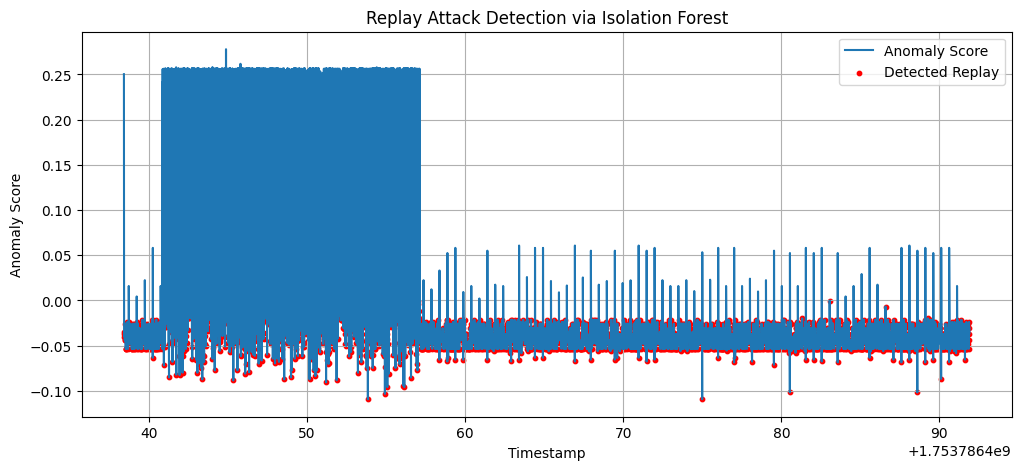

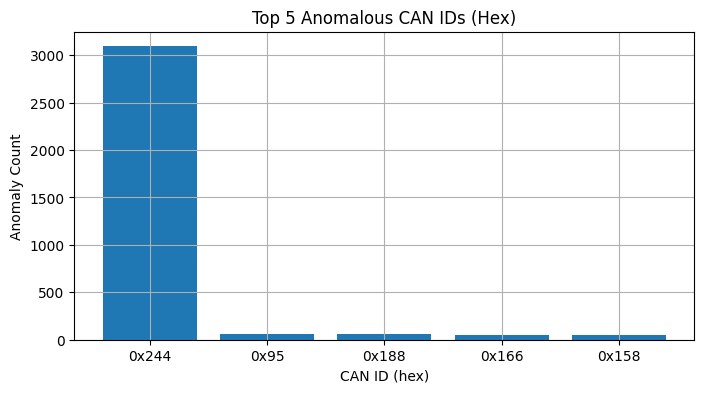

In [6]:
# SECTION 4: Visualization (Hex CAN IDs)
import matplotlib.pyplot as plt

# Timeseries chart of anomaly scores
plt.figure(figsize=(12, 5))
plt.plot(features_replay['timestamp'], features_replay['anomaly_score'], label='Anomaly Score')
plt.scatter(
    features_replay[features_replay['anomaly'] == 1]['timestamp'],
    features_replay[features_replay['anomaly'] == 1]['anomaly_score'],
    color='red', label='Detected Replay', s=10
)
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("Replay Attack Detection via Isolation Forest")
plt.legend()
plt.grid(True)
plt.show()

# Top 5 Anomalous CAN IDs (in hex)
top_ids = features_replay[features_replay['anomaly'] == 1]['can_id'].value_counts().head(5)

plt.figure(figsize=(8, 4))
plt.bar([hex(cid) for cid in top_ids.index], top_ids.values)
plt.title("Top 5 Anomalous CAN IDs (Hex)")
plt.xlabel("CAN ID (hex)")
plt.ylabel("Anomaly Count")
plt.grid(True)
plt.show()


In [7]:
# Compare how often sequences repeat (using a rolling hash window)
from collections import defaultdict

def find_replay_patterns(df, window=10):
    """Detect repeating message sequences via rolling window."""
    seq_map = defaultdict(list)
    hashes = []
    for i in range(len(df) - window):
        slice = df.iloc[i:i+window][['can_id']].values.flatten()
        key = hash(tuple(slice))
        seq_map[key].append(i)
        hashes.append(key)
    return [k for k, v in seq_map.items() if len(v) > 1]

repeated_patterns = find_replay_patterns(features_replay)
print(f"🧠 Detected {len(repeated_patterns)} suspicious repeated sequences.")


🧠 Detected 3751 suspicious repeated sequences.


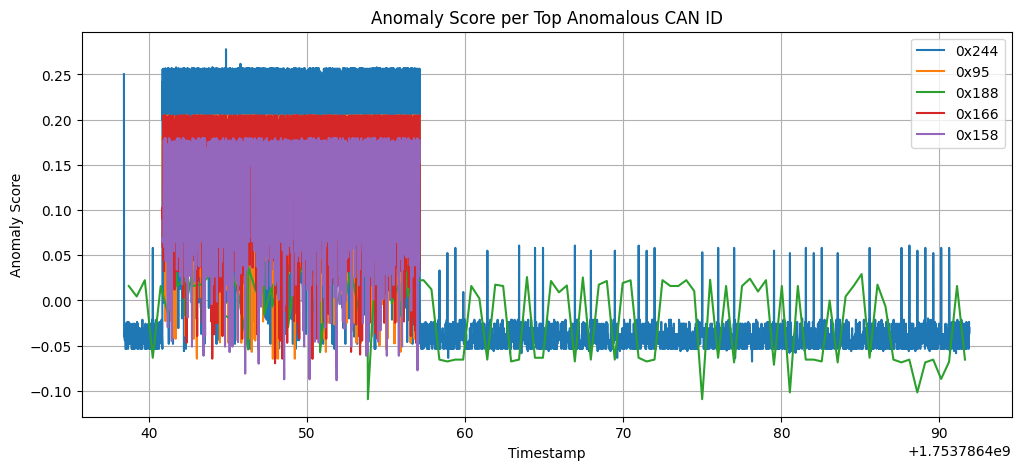

In [8]:
# Time-series anomaly markers per CAN ID
plt.figure(figsize=(12, 5))
for can_id in top_ids.index:
    subset = features_replay[features_replay['can_id'] == can_id]
    plt.plot(subset['timestamp'], subset['anomaly_score'], label=hex(can_id))

plt.title("Anomaly Score per Top Anomalous CAN ID")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# SECTION 5: LSTM Autoencoder for Sequence Anomaly Detection
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Create sequences (e.g., 10-step sequences for LSTM input)
def create_sequences(df, seq_len=10):
    X = []
    features = df[['delta_t', 'id_freq', 'payload_entropy']].values
    for i in range(len(features) - seq_len):
        X.append(features[i:i + seq_len])
    return np.array(X)

# Step 1: Scale features
scaler = MinMaxScaler()
scaled_normal = scaler.fit_transform(features_normal[['delta_t', 'id_freq', 'payload_entropy']])
scaled_replay = scaler.transform(features_replay[['delta_t', 'id_freq', 'payload_entropy']])

# Step 2: Reconstruct DataFrames with column names
feature_names = ['delta_t', 'id_freq', 'payload_entropy']
df_scaled_normal = pd.DataFrame(scaled_normal, columns=feature_names)
df_scaled_replay = pd.DataFrame(scaled_replay, columns=feature_names)

# Step 3: Create sequences from scaled data
seq_len = 10
X_train = create_sequences(df_scaled_normal, seq_len)
X_test = create_sequences(df_scaled_replay, seq_len)

# Step 4: Define LSTM Autoencoder
timesteps, n_features = X_train.shape[1], X_train.shape[2]
inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu')(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Step 5: Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 3)          │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,627 (197.76 KB)

 Trainable params: 50,627 (197.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 0.0573 - val_loss: 0.0198
Epoch 2/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - loss: 0.0176 - val_loss: 0.0139
Epoch 3/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 0.0130 - val_loss: 0.0112
Epoch 4/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.0105 - val_loss: 0.0090
Epoch 5/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0086 - val_loss: 0.0075
Epoch 6/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 7/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 8/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 9/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 10/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.0031 - val_loss: 0.0027


Epoch 1/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 2/50
1114/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 3/50
1114/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/50
1115/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/50
1113/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 0.0012 - val_loss: 9.2670e-04
Epoch 6/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.7566e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 9.7563e-04 - val_loss: 7.8331e-04
Epoch 7/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 8.3468e-04 - val_loss: 8.1411e-04
Epoch 8/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.3798e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 7.3795e-04 - val_loss: 5.3916e-04
Epoch 9/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 6.4097e-04 - val_loss: 6.7963e-04
Epoch 10/50
1115/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.5410e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 5.5407e-04 - val_loss: 4.7181e-04
Epoch 11/50
1114/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.9884e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 4.9877e-04 - val_loss: 4.4941e-04
Epoch 12/50
1115/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.2911e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 4.2909e-04 - val_loss: 4.1755e-04
Epoch 13/50
1114/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.8371e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 3.8371e-04 - val_loss: 3.1955e-04
Epoch 14/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 3.4913e-04 - val_loss: 3.4024e-04
Epoch 15/50
1114/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.2193e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 3.2193e-04 - val_loss: 2.8380e-04
Epoch 16/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 3.1216e-04 - val_loss: 2.9617e-04
Epoch 17/50
1114/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.8330e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 2.8329e-04 - val_loss: 2.4757e-04
Epoch 18/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 2.6732e-04 - val_loss: 2.8503e-04
Epoch 19/50
1115/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.5009e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 2.5009e-04 - val_loss: 2.4108e-04
Epoch 20/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.4222e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 2.4221e-04 - val_loss: 2.2237e-04
Epoch 21/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.2467e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 2.2467e-04 - val_loss: 2.1075e-04
Epoch 22/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 2.0344e-04 - val_loss: 2.1712e-04
Epoch 23/50
1114/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.9941e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 1.9940e-04 - val_loss: 1.6992e-04
Epoch 24/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 1.8608e-04 - val_loss: 1.8794e-04
Epoch 25/50
1114/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6523e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 1.6522e-04 - val_loss: 1.1580e-04
Epoch 26/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - loss: 1.5240e-04 - val_loss: 2.0051e-04
Epoch 27/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3947e-04

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 1.3947e-04 - val_loss: 8.3477e-05
Epoch 28/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 1.3424e-04 - val_loss: 1.0374e-04
Epoch 29/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 1.1790e-04 - val_loss: 2.2810e-04
Epoch 30/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 1.1457e-04 - val_loss: 1.3569e-04


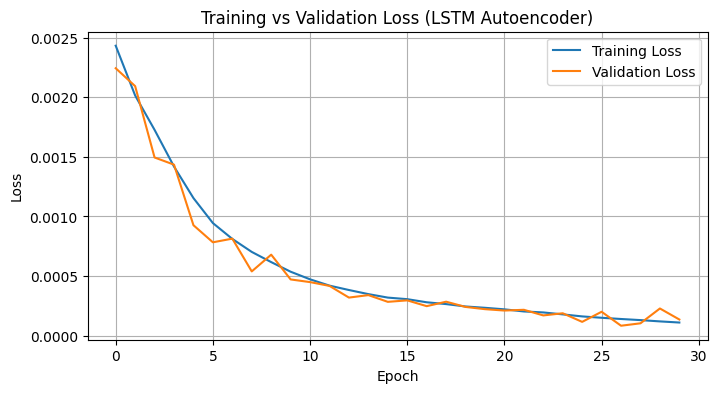

1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
⚠️ Anomalous sequences: 1819 / 36372


In [13]:
# SECTION 6: LSTM-Based Anomaly Scores on Replay Data with Enhancements
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Create checkpoint directory
os.makedirs("models", exist_ok=True)

# Define callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_ckpt = ModelCheckpoint("models/lstm_autoencoder.h5", save_best_only=True, monitor="val_loss")

# Retrain with callbacks and more epochs
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop, model_ckpt]
)

# Plot training vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (LSTM Autoencoder)")
plt.legend()
plt.grid(True)
plt.show()

# Generate predictions on replay sequences
X_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1, 2))

# Anomaly threshold at 95th percentile of training reconstruction error
threshold = np.percentile(mse, 95)
anomaly_flags = (mse > threshold).astype(int)

print(f"⚠️ Anomalous sequences: {np.sum(anomaly_flags)} / {len(mse)}")


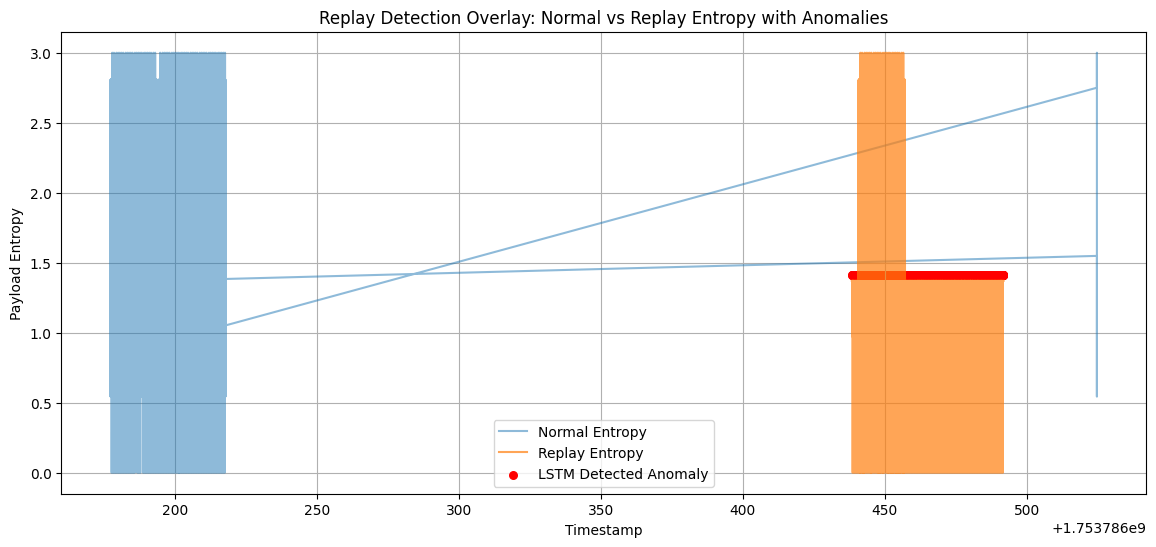

In [14]:
# SECTION 7: Visual Overlay of Replay Anomalies with Normal Comparison
# Get timestamp centers for each replay sequence window
window_centers = features_replay['timestamp'].values[seq_len:len(mse)+seq_len]

# Create base plot comparing entropy in normal vs replay
plt.figure(figsize=(14, 6))
plt.plot(features_normal['timestamp'], features_normal['payload_entropy'], label='Normal Entropy', alpha=0.5)
plt.plot(features_replay['timestamp'], features_replay['payload_entropy'], label='Replay Entropy', alpha=0.7)

# Highlight anomaly windows from LSTM
plt.scatter(
    window_centers[anomaly_flags == 1],
    [features_replay['payload_entropy'].mean()] * sum(anomaly_flags),
    color='red', label='LSTM Detected Anomaly', s=30
)

plt.title("Replay Detection Overlay: Normal vs Replay Entropy with Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("Payload Entropy")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# SECTION 8 (FIXED): Extract CAN ID + Payload Patterns of Anomalous Sequences
from collections import Counter

anomalous_windows = []

# i corresponds to the start of the LSTM window in features_replay
for i, flag in enumerate(anomaly_flags):
    if flag == 1:
        window = features_replay.iloc[i:i + seq_len]
        byte_cols = [col for col in features_replay.columns if col.startswith('byte_')]
        window_data = window[['can_id'] + byte_cols]
        anomalous_windows.append(window_data)

# Count CAN ID + Payload pairs
pattern_counter = Counter()

for window in anomalous_windows:
    for _, row in window.iterrows():
        can_id = f"{int(row['can_id']):#04x}"
        payload = '-'.join(f"{int(b):02x}" for b in row[1:] if not pd.isnull(b))
        pattern_counter[(can_id, payload)] += 1

# Show top 10 patterns
top_patterns = pattern_counter.most_common(10)

print("🛑 Top 10 Replayed CAN ID + Payload Patterns Detected:")
for idx, ((can_id, payload), count) in enumerate(top_patterns, 1):
    print(f"{idx}. CAN ID: {can_id}, Payload: [{payload}], Count: {count}")


🛑 Top 10 Replayed CAN ID + Payload Patterns Detected:
1. CAN ID: 0x244, Payload: [], Count: 9378
2. CAN ID: 0x95, Payload: [], Count: 645
3. CAN ID: 0x166, Payload: [], Count: 628
4. CAN ID: 0x158, Payload: [], Count: 546
5. CAN ID: 0x143, Payload: [], Count: 524
6. CAN ID: 0x161, Payload: [], Count: 512
7. CAN ID: 0x188, Payload: [], Count: 480
8. CAN ID: 0x183, Payload: [], Count: 442
9. CAN ID: 0x191, Payload: [], Count: 427
10. CAN ID: 0x39, Payload: [], Count: 339
